In [1]:
import sys
sys.version

'2.7.12 (default, Nov 12 2018, 14:36:49) \n[GCC 5.4.0 20160609]'

# Data Process

In [2]:
#import pyrealsense2 as rs
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import joblib
#import scipy.misc
import tensorflow as tf
#from skimage.restoration import denoise_tv_chambolle
from tensorboardX import SummaryWriter
import copy

/usr/local/lib/python2.7/dist-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [3]:
pp_path = '/home/obin/t2b_dataset/rgbd/image'
data_list = np.sort([pp_path+'/'+x for x in os.listdir(os.path.join(pp_path,''))])
# pp_path = '/home/obin/t2b_dataset/pickandplace/temp/0202'
# data_list2 = np.sort([pp_path+'/'+x for x in os.listdir(os.path.join(pp_path,''))])
# data_list = np.hstack((data_list[0:-1],data_list2))
num_data = len(data_list)
print('num of data : ', num_data)

('num of data : ', 1000)


## depth image preprocess

In [4]:
#np.random.shuffle(data_list)
data_list

array(['/home/obin/t2b_dataset/rgbd/image/0000.png',
       '/home/obin/t2b_dataset/rgbd/image/0001.png',
       '/home/obin/t2b_dataset/rgbd/image/0002.png',
       '/home/obin/t2b_dataset/rgbd/image/0003.png',
       '/home/obin/t2b_dataset/rgbd/image/0004.png',
       '/home/obin/t2b_dataset/rgbd/image/0005.png',
       '/home/obin/t2b_dataset/rgbd/image/0006.png',
       '/home/obin/t2b_dataset/rgbd/image/0007.png',
       '/home/obin/t2b_dataset/rgbd/image/0008.png',
       '/home/obin/t2b_dataset/rgbd/image/0009.png',
       '/home/obin/t2b_dataset/rgbd/image/0010.png',
       '/home/obin/t2b_dataset/rgbd/image/0011.png',
       '/home/obin/t2b_dataset/rgbd/image/0012.png',
       '/home/obin/t2b_dataset/rgbd/image/0013.png',
       '/home/obin/t2b_dataset/rgbd/image/0014.png',
       '/home/obin/t2b_dataset/rgbd/image/0015.png',
       '/home/obin/t2b_dataset/rgbd/image/0016.png',
       '/home/obin/t2b_dataset/rgbd/image/0017.png',
       '/home/obin/t2b_dataset/rgbd/image/0018

In [5]:
def overlap(r1,r2):
    hoverlaps = not((r1[0] > r2[1]) or (r1[1] < r2[0]))
    voverlaps = not((r1[3] < r2[2]) or (r1[2] > r2[3]))
    return hoverlaps and voverlaps  

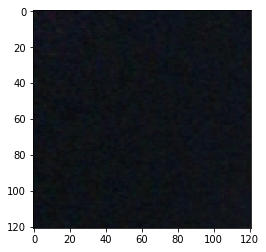

In [6]:
img = cv2.imread('/home/obin/t2b_dataset/rgbd/image/0012.png')
black_patch = img[10:131,10:131,:]
black_patch = cv2.cvtColor(black_patch,cv2.COLOR_BGR2RGB)
plt.imshow(black_patch)

In [7]:
safe_distance = 3
max_move1 = 20
max_move2 = 20

In [8]:
def draw_circle(event,x,y,flags,param):
    global mouseX,mouseY
    if event == cv2.EVENT_LBUTTONDBLCLK:
        #cv2.circle(i,(x,y),10000,(255,0,0),-1)
        mouseX,mouseY = x,y
        #print('point x:{0}, y:{1}'.format(mouseX,mouseY))

In [9]:
def extract_objects(img,safe_distance=5):
    kernel = np.ones((3,3),np.float32)/(3*2)
    img = cv2.filter2D(img,-1,kernel)
    for tx in range(256):
        for ty in range(256):
            color = np.array(img[tx,ty,:],dtype=np.int64)
            if (abs(color[0]-color[1]) < 30) and (abs(color[1]-color[2]) < 30): 
                img[tx,ty,:] = [30,30,30]

    imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray,50,255,0)
    image, contours, hierachy = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    hulls = []
    for c in contours :
        if np.array(c).shape[0] <= 1 : continue
        hulls.append(cv2.convexHull(c))
    
    image = cv2.drawContours(img, hulls, -1, (0,255,0), 3)
    object_list = []
    for h in hulls :
        x = np.array(h).squeeze()[:,0]
        y = np.array(h).squeeze()[:,1]
        (topx, topy) = (np.min(x), np.min(y))
        (bottomx, bottomy) = (np.max(x), np.max(y))
        #out = np.zeros_like(img)
        dx = bottomx - topx
        dy = bottomy - topy


        out = img[topy:bottomy+1,topx:bottomx+1:]
        mean = np.mean(out, axis=(0,1))

        if dx*dy <= 800 : continue
        if (abs(mean[0] - mean[1]) < 20)and(abs(mean[1] - mean[2]) < 20) : continue
            
        obj = [topx-safe_distance,bottomx+safe_distance,
               topy-safe_distance,bottomy+safe_distance]
    
        object_list.append(np.clip(obj,0,255))
        
    return hulls, object_list
    

In [10]:
def where_is(pose,objs):
    for idx, obj in enumerate(objs):
        x_ok = obj[0] < pose[0] and obj[1] > pose[0] 
        y_ok = obj[2] < pose[1] and obj[3] > pose[1]
        
        if x_ok and y_ok : return idx
    return -1
            

In [11]:
def move_object(ids,move,object_list,img,black_patch):
    #print('move ', move)
    ob = object_list[ids]
    
    moved_ob = np.array(ob-move,dtype=np.int64)
    if not(all(moved_ob<255) and all(moved_ob>0)) : 
        return False, None, None
    #   print('moved', moved_ob)
    safe_flag = False
    for other_ob in object_list :
        if overlap(moved_ob,other_ob) and any(other_ob != ob) :
            safe_flag=False
            return False, None, None
        safe_flag = True
    object_img = copy.deepcopy(img[ob[2]:ob[3]+1,ob[0]:ob[1]+1,:])

    if safe_flag : 
        dy = ob[3] - ob[2] + 1
        dx = ob[1] - ob[0] + 1
        img[ob[2]:ob[3]+1,ob[0]:ob[1]+1,:] = black_patch[0:dy,0:dx,:]
        img[moved_ob[2]:moved_ob[3]+1, moved_ob[0]:moved_ob[1]+1, :] = object_img
        object_list[ids] = moved_ob
        return True, img, object_list

    return False, None, None

In [12]:
orig_imgs = []
end_scenario = []
resume = 0
for i in range(resume, num_data-1):

    s_img = cv2.imread(data_list[i])
    e_img = cv2.imread(data_list[i+1])

    s_hulls,s_objs = extract_objects(s_img)
    e_hulls,e_objs = extract_objects(e_img)

    
#     fig = plt.figure(figsize=(12,12))
#     s_ax = fig.add_subplot(141)
    s_img = cv2.cvtColor(s_img,cv2.COLOR_BGR2RGB)
#     s_ax.imshow(s_img)
#     e_ax = fig.add_subplot(142)
    e_img = cv2.cvtColor(e_img,cv2.COLOR_BGR2RGB)
#     e_ax.imshow(e_img)    
#     s_ax2 = fig.add_subplot(143)
#     s_ax2.imshow(s_img)
#     e_ax2 = fig.add_subplot(144)
#     e_ax2.imshow(e_img)
    
    #plt.show()

    data_dict = dict()
    pair_idx = []
    no_care_idx = []
    
    paired_e_idx = []
    for s_idx, s_ob in enumerate(s_objs) :
        s_counter = np.array([np.mean(s_ob[0:2]),np.mean(s_ob[2:4])])
        #s_ax2.scatter(s_counter[0],s_counter[1],10,'white')
        for tr in range(4):
            e_idx = where_is(s_counter,e_objs)
            if e_idx != -1 :
                sd = int(min(s_ob[1] - s_ob[0],s_ob[3] - s_ob[2])/4.0)
                a = [sd,sd]
                iz = int(tr/2.0)
                a[iz] = np.power(-1, tr) * sd 
                e_idx = where_is(s_counter-a,e_objs)

        if e_idx != -1 :
            e_ob = e_objs[e_idx]
            pair_idx.append([s_idx,e_idx])
            paired_e_idx.append(e_idx)

            randcolor = (np.random.randint(0,100,size=3) + np.array([10,10,150]))/255.0
#             rect = patches.Rectangle((s_ob[0],s_ob[2]),s_ob[1]-s_ob[0],s_ob[3]-s_ob[2],
#                                      linewidth=0.1,edgecolor=randcolor,facecolor=randcolor)
#             s_ax.add_patch(rect)

            
#             rect = patches.Rectangle((e_ob[0],e_ob[2]),e_ob[1]-e_ob[0],e_ob[3]-e_ob[2],
#                                      linewidth=0.1,edgecolor=randcolor,facecolor=randcolor)
#             e_ax.add_patch(rect)
            
        else :
#             randcolor = (np.random.randint(0,50,size=3) + np.array([200,0,0]))/255.0
#             rect = patches.Rectangle((s_ob[0],s_ob[2]),s_ob[1]-s_ob[0],s_ob[3]-s_ob[2],
#                                      linewidth=0.1,edgecolor=randcolor,facecolor=randcolor)
#             s_ax.add_patch(rect)
            no_care_idx.append([0,s_idx])
    
    for k in range(len(e_objs)):
        if k in paired_e_idx : continue
        else : 
            e_ob = e_objs[k]
#             randcolor = (np.random.randint(0,50,size=3) + np.array([200,0,0]))/255.0
#             rect = patches.Rectangle((e_ob[0],e_ob[2]),e_ob[1]-e_ob[0],e_ob[3]-e_ob[2],
#                      linewidth=0.1,edgecolor=randcolor,facecolor=randcolor)
#             e_ax.add_patch(rect)
            no_care_idx.append([1,k])
    
    plt.show()
    if len(pair_idx) == 0 :
        print('-'*50)
        print('end')
        print('\n\n')
        continue
        
    else :
        data_dict['start_image'] = s_img
        data_dict['end_image'] = e_img
        data_dict['pair_idx'] = pair_idx
        data_dict['no_care_idx'] = no_care_idx
        data_dict['start_objects'] = s_objs
        data_dict['end_objects'] = e_objs
        data_dict['start_hulls'] = s_hulls
        data_dict['end_hulls'] = e_hulls

        data_name = os.path.join('/home/obin/t2b_dataset/rgbd/sampled', '%04d.dat.gz'%i)
        joblib.dump(data_dict,data_name)
        print(data_name)

            

            
    

/home/obin/t2b_dataset/rgbd/sampled/0000.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0001.dat.gz
--------------------------------------------------
end



/home/obin/t2b_dataset/rgbd/sampled/0003.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0004.dat.gz
--------------------------------------------------
end



/home/obin/t2b_dataset/rgbd/sampled/0006.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0007.dat.gz
--------------------------------------------------
end



/home/obin/t2b_dataset/rgbd/sampled/0009.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0010.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0011.dat.gz
--------------------------------------------------
end



/home/obin/t2b_dataset/rgbd/sampled/0013.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0014.dat.gz
--------------------------------------------------
end



/home/obin/t2b_dataset/rgbd/sampled/0016.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0017.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0018.dat.gz
--------------------------------------

/home/obin/t2b_dataset/rgbd/sampled/0165.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0166.dat.gz
--------------------------------------------------
end



/home/obin/t2b_dataset/rgbd/sampled/0168.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0169.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0170.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0171.dat.gz
--------------------------------------------------
end



/home/obin/t2b_dataset/rgbd/sampled/0173.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0174.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0175.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0176.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0177.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0178.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0179.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0180.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0181.dat.gz
--------------------------------------------------
end



/home/obin/t2b_dataset/rgbd/sampled/0183.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0184.dat.gz
/home/obin

/home/obin/t2b_dataset/rgbd/sampled/0332.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0333.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0334.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0335.dat.gz
--------------------------------------------------
end



/home/obin/t2b_dataset/rgbd/sampled/0337.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0338.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0339.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0340.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0341.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0342.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0343.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0344.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0345.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0346.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0347.dat.gz
--------------------------------------------------
end



/home/obin/t2b_dataset/rgbd/sampled/0349.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0350.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0351.dat.gz
/home/obin/t2b_datas

/home/obin/t2b_dataset/rgbd/sampled/0499.dat.gz
--------------------------------------------------
end



/home/obin/t2b_dataset/rgbd/sampled/0501.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0502.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0503.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0504.dat.gz
--------------------------------------------------
end



/home/obin/t2b_dataset/rgbd/sampled/0506.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0507.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0508.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0509.dat.gz
--------------------------------------------------
end



/home/obin/t2b_dataset/rgbd/sampled/0511.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0512.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0513.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0514.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0515.dat.gz
--------------------------------------------------
end



/home/obin/t2b_dataset/rgbd/sampled/0517.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0518.dat.gz


/home/obin/t2b_dataset/rgbd/sampled/0665.dat.gz
--------------------------------------------------
end



/home/obin/t2b_dataset/rgbd/sampled/0667.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0668.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0669.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0670.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0671.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0672.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0673.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0674.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0675.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0676.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0677.dat.gz
--------------------------------------------------
end



/home/obin/t2b_dataset/rgbd/sampled/0679.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0680.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0681.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0682.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0683.dat.gz
--------------------------------------------------
end



/home/obin

/home/obin/t2b_dataset/rgbd/sampled/0831.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0832.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0833.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0834.dat.gz
--------------------------------------------------
end



/home/obin/t2b_dataset/rgbd/sampled/0836.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0837.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0838.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0839.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0840.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0841.dat.gz
--------------------------------------------------
end



/home/obin/t2b_dataset/rgbd/sampled/0843.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0844.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0845.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0846.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0847.dat.gz
/home/obin/t2b_dataset/rgbd/sampled/0848.dat.gz
--------------------------------------------------
end



/home/obin/t2b_dataset/rgbd/sampled/0850.dat.gz
/home/obin

/home/obin/t2b_dataset/rgbd/sampled/0998.dat.gz


In [13]:
data_path = '/home/obin/t2b_dataset/rgbd/sampled'
spd_list = np.sort([data_path+'/'+x for x in os.listdir(os.path.join(data_path,''))])
num_data = len(spd_list)

In [14]:
# resume = 0
# for i in range(resume, num_data):
#     curr_data = joblib.load(spd_list[i])
#     print('-------------scene {0}-------------'.format(i))
#     s_img = copy.deepcopy(curr_data['start_image'])
#     e_img = copy.deepcopy(curr_data['end_image'])
#     pair_idx = curr_data['pair_idx']
#     no_care_idx = curr_data['no_care_idx']
#     s_objs = curr_data['start_objects']
#     e_objs = curr_data['end_objects']
#     s_hulls = curr_data['start_hulls']
#     e_hulls = curr_data['end_hulls']
    
    
#     fig = plt.figure(figsize=(12,12))
#     s_ax = fig.add_subplot(141)

#     s_ax.imshow(s_img)
#     e_ax = fig.add_subplot(142)
#     e_ax.imshow(e_img)    
#     s_ax2 = fig.add_subplot(143)
#     s_ax2.imshow(s_img)
#     e_ax2 = fig.add_subplot(144)
#     e_ax2.imshow(e_img)
    
#     for pair in pair_idx:
#         s_ob = s_objs[pair[0]]
#         e_ob = e_objs[pair[1]]
        
#         randcolor = (np.random.randint(0,100,size=3) + np.array([10,10,150]))/255.0
#         rect = patches.Rectangle((s_ob[0],s_ob[2]),s_ob[1]-s_ob[0],s_ob[3]-s_ob[2],
#                                  linewidth=3,edgecolor=randcolor,facecolor=randcolor)
#         s_ax.add_patch(rect)
        
#         rect = patches.Rectangle((e_ob[0],e_ob[2]),e_ob[1]-e_ob[0],e_ob[3]-e_ob[2],
#                                  linewidth=3,edgecolor=randcolor,facecolor=randcolor)
#         e_ax.add_patch(rect)
    
#     for idx in no_care_idx :
#         if idx[0] == 0 :
#             s_ob = s_objs[idx[1]]
#             randcolor = (np.random.randint(0,50,size=3) + np.array([200,0,0]))/255.0
#             rect = patches.Rectangle((s_ob[0],s_ob[2]),s_ob[1]-s_ob[0],s_ob[3]-s_ob[2],
#                                      linewidth=3,edgecolor=randcolor,facecolor=randcolor)
#             s_ax.add_patch(rect)
            
#         elif idx[0] == 1 :
#             e_ob = e_objs[idx[1]]
#             randcolor = (np.random.randint(0,50,size=3) + np.array([200,0,0]))/255.0
#             rect = patches.Rectangle((e_ob[0],e_ob[2]),e_ob[1]-e_ob[0],e_ob[3]-e_ob[2],
#                                      linewidth=0.1,edgecolor=randcolor,facecolor=randcolor)
#             e_ax.add_patch(rect)
        
#     plt.show()

    


In [15]:
resume = 0
howmany = 10
for i in range(resume, num_data):
    for j in range(howmany):
        curr_data = joblib.load(spd_list[i])
        print('-------------scene {0}, {1}th generation-------------'.format(i,j))
        s_img = copy.deepcopy(curr_data['start_image'])
        e_img = copy.deepcopy(curr_data['end_image'])
        pair_idx = curr_data['pair_idx']
        no_care_idx = curr_data['no_care_idx']
        s_objs = curr_data['start_objects']
        e_objs = curr_data['end_objects']
        s_hulls = curr_data['start_hulls']
        e_hulls = curr_data['end_hulls']


        for pair in pair_idx :
            for tr in range(6):
                move = np.ones(4)
                move[0:2] *= np.random.randint(-max_move1,max_move1+1)
                move[2:4] *= np.random.randint(-max_move1,max_move1+1)
                s, s_moved_img, s_moved_objs = move_object(pair[0],move,s_objs,s_img,black_patch)
                e, e_moved_img, e_moved_objs = move_object(pair[1],move,e_objs,e_img,black_patch)
                if s and e : 
                    s_img = s_moved_img
                    e_img = e_moved_img
                    s_objs = s_moved_objs
                    e_objs = e_moved_objs
                    break

        for idx in no_care_idx :
            for tr in range(6):
                move = np.ones(4)
                move[0:2] *= np.random.randint(-max_move2,max_move2+1)
                move[2:4] *= np.random.randint(-max_move2,max_move2+1)

                if idx[0] == 0 : 
                    result, moved_img, s_moved_objs = move_object(idx[1],move,s_objs,s_img,black_patch)
                elif idx[0] == 1:
                    result, moved_img, e_moved_objs = move_object(idx[1],move,e_objs,e_img,black_patch)

                if result and idx[0] == 0 :
                    s_img = moved_img
                    s_objs = s_moved_objs
                    break
                elif result and idx[0] == 1 :
                    e_img = moved_img
                    e_objs = e_moved_objs
                    break

        plt.figure(figsize=(14,14))
        plt.subplot(121)
        plt.imshow(s_img)
        plt.subplot(122)

        plt.imshow(e_img)
        plt.show()

        plt.figure(figsize=(12,12))
        plt.subplot(131)
        s_overlap = cv2.addWeighted(curr_data['start_image'],0.3,s_img,0.7,0)
        plt.imshow(s_overlap)
        plt.subplot(132)
        c_overlap = cv2.addWeighted(curr_data['end_image'],0.3,e_img,0.7,0)
        plt.imshow(c_overlap)
        plt.subplot(133)
        plt.imshow(cv2.addWeighted(s_img,0.5,e_img,0.5,0))
        plt.show()
        print('-'*50)
        print('\n\n\n')

        save_path = os.path.join(data_path,'%04d'%i)
        if not os.path.exists(save_path): 
            os.mkdir(save_path)
            os.mkdir(os.path.join(save_path,'dat'))
            os.mkdir(os.path.join(save_path,'img'))
        save_data = [s_img,e_img,s_overlap,c_overlap]
        joblib.dump(save_data,os.path.join(save_path,'dat/%02d.dat.gz'%j))
        stacked_img = np.hstack([s_img,e_img])
        plt.imsave(os.path.join(save_path,'img/%02d.png'%j),stacked_img)
        

        
    

IOError: [Errno 21] Is a directory: '/home/obin/t2b_dataset/rgbd/sampled/0000'